In [2]:
import os
os.chdir('/data/l989o/deployed/a')
import sys
if '/data/l989o/a' in sys.path:
    sys.path.remove('/data/l989o/a')
print(os.getcwd())
import numpy as np
from jupy import *

/data/l989o/deployed/a


In [3]:
import h5py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np
import torch
import os

In [4]:
a = '/data/l989o/deployed/a/data/spatial_uzh_processed/a/'
instances = [
    '/data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_transformed_mean_dataset_LR_VB_S_0.0001__1e-06__False',
    '/data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_transformed_mean_dataset_LR_VB_S_0.0014685885989200848__3.8608662714605464e-08__False',
    '/data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_transformed_mean_dataset_LD_2',
    '/data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_transformed_mean_dataset_LD_3'
]
assert np.prod([os.path.isdir(a) for a in instances])

In [5]:
train_losses = dict()
validation_losses = dict()

for ll in instances:
    name = os.path.basename(ll)
    train_losses[name] = dict()
    validation_losses[name] = dict()
    with h5py.File(os.path.join(ll, 'training_logger.hdf5'), 'r') as f5:
        keys = f5.keys()
        epochs = sorted([int(k.split('epoch')[1]) for k in keys])
        sorted_epochs_strings = [f'epoch{epoch}' for epoch in epochs]
        for i, s in enumerate(sorted_epochs_strings):
            epoch = epochs[i]
            train_loss = f5[s]['training_evaluator']['loss'][...]
            train_losses[name][epoch] = train_loss
            validation_loss = f5[s]['validation_evaluator']['loss'][...]
            validation_losses[name][epoch] = validation_loss
train_traces = []
for name, losses in train_losses.items():
    visible = True
    if name in ['raw_vae']:
        visible = 'legendonly'
    trace = go.Scatter(x=list(losses.keys()), y=list(losses.values()), name=name, visible=visible)
    train_traces.append(trace)
validation_traces = []
for name, losses in validation_losses.items():
    visible = True
    if name in ['raw_vae']:
        visible = 'legendonly'
    trace = go.Scatter(x=list(losses.keys()), y=list(losses.values()), name=name, visible=visible)
    validation_traces.append(trace)        

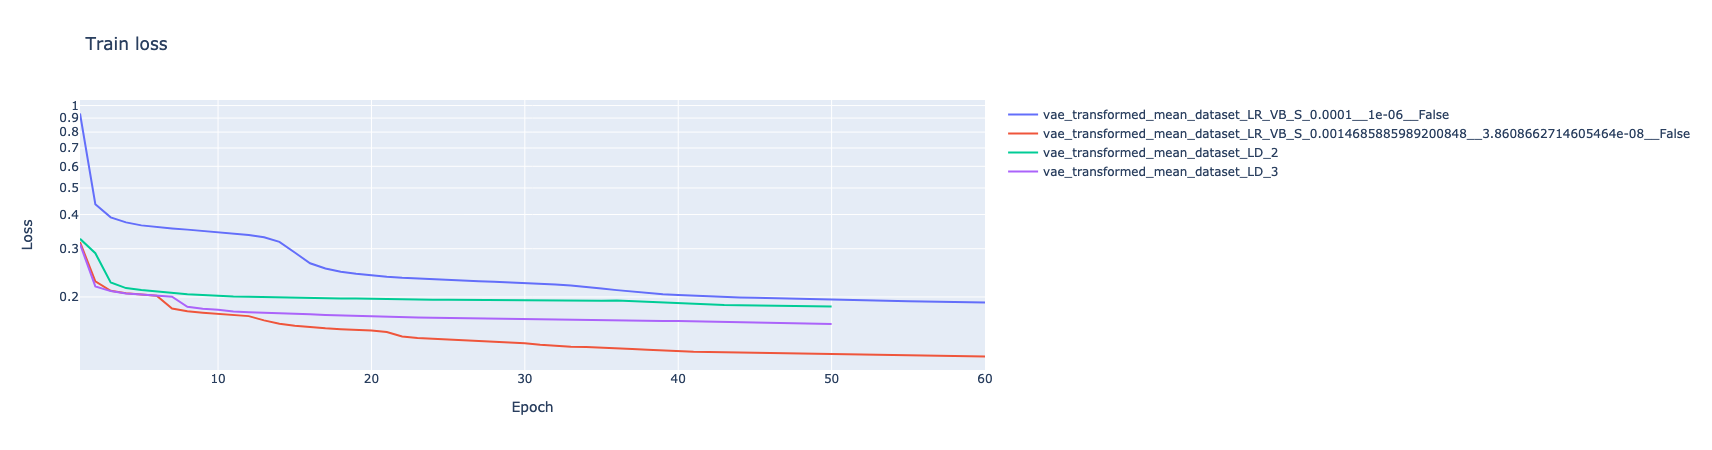

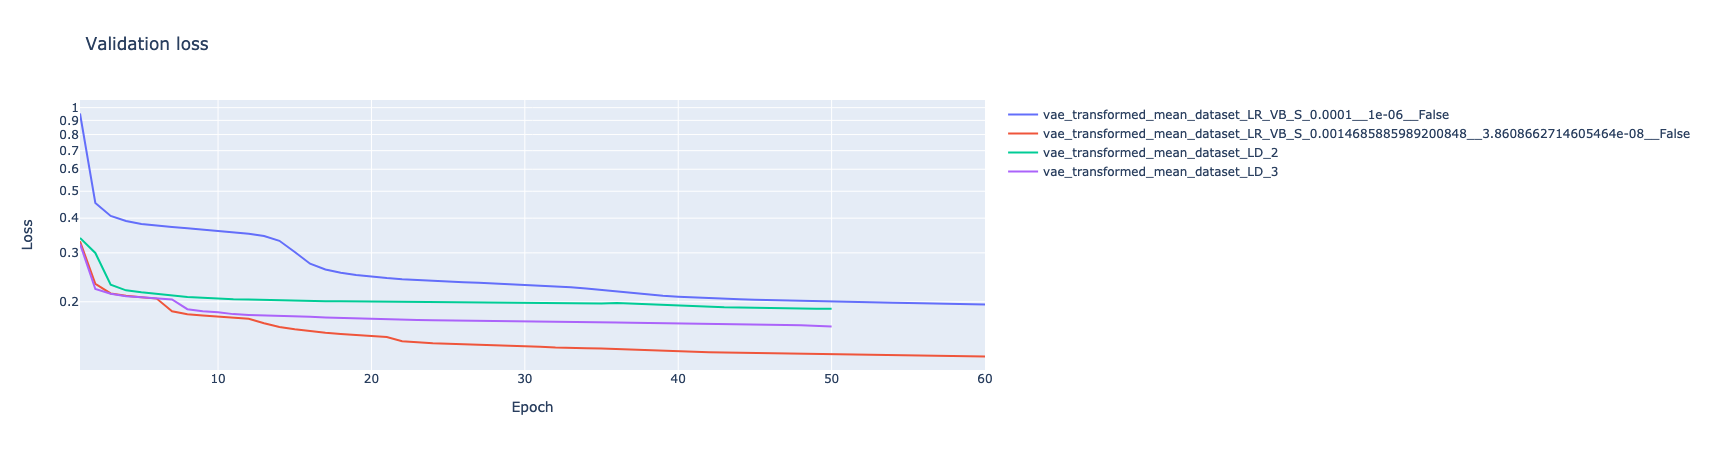

In [6]:
train_layout = go.Layout(
    title='Train loss',
    xaxis_title='Epoch',
    yaxis_title='Loss',
    yaxis=dict(
        type='log'
    ),
)
fig = go.Figure(data=train_traces, layout=train_layout)
iplot(fig)

validation_layout = go.Layout(
    title='Validation loss',
    xaxis_title='Epoch',
    yaxis_title='Loss',
    yaxis=dict(
        type='log'
    ),
)
fig = go.Figure(data=validation_traces, layout=validation_layout)
iplot(fig)


In [7]:
all_epochs = set()
for v in train_losses.values():
    all_epochs |= set(v.keys())

train_metrics_by_epoch = dict()
validation_metrics_by_epoch = dict()
for epoch in all_epochs:
    train_metrics_by_epoch[epoch] = dict()
    validation_metrics_by_epoch[epoch] = dict()
    for (k_train, v_train), (k_validation, v_validation) in zip(train_losses.items(), 
                                                                validation_losses.items()):
        assert k_train == k_validation
        vv_train = v_train[epoch] if epoch in v_train else None
        vv_validation = v_validation[epoch] if epoch in v_validation else None
        if vv_train is not None:
            train_metrics_by_epoch[epoch][k_train] = vv_train
        if vv_validation is not None:
            validation_metrics_by_epoch[epoch][k_validation] = vv_validation

#%%

# x and y are items of a dictionary, each of the values is either a float either None
# we sort the float ascendingly, and we consider the None as higher that every other value
l = lambda d: {k: {kk: vv for kk, vv in sorted(v.items(), key=lambda x: x[1])} for k, v in d.items()}
sorted_train = l(train_metrics_by_epoch)
sorted_validation = l(validation_metrics_by_epoch)

#%%

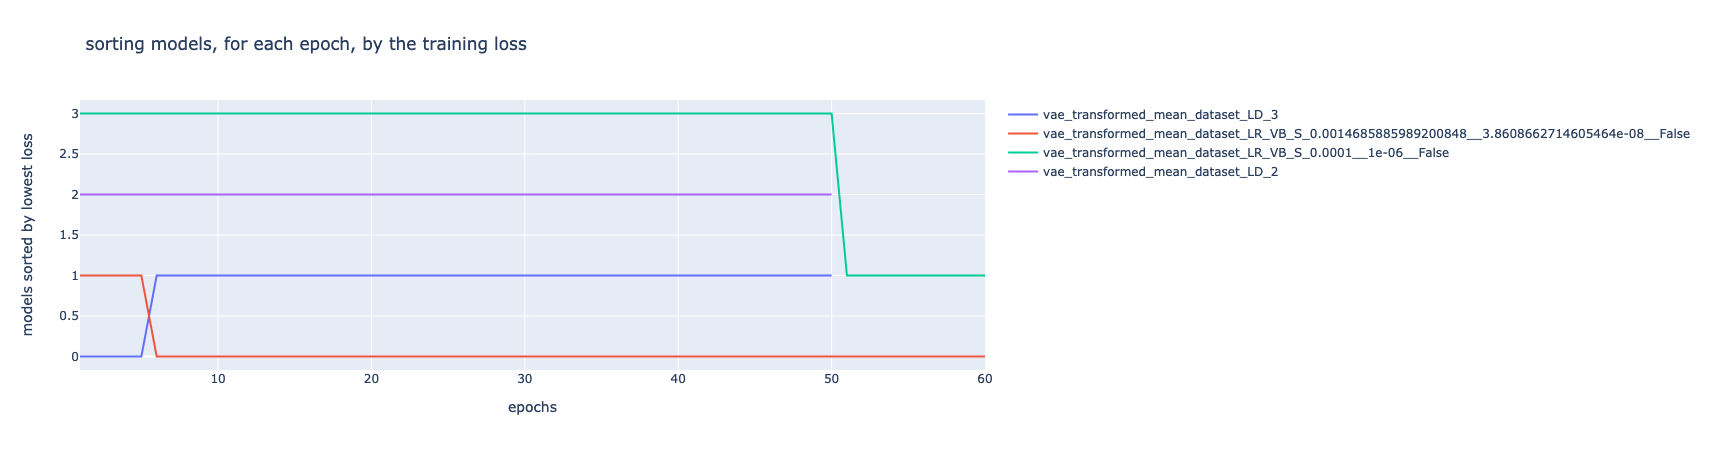

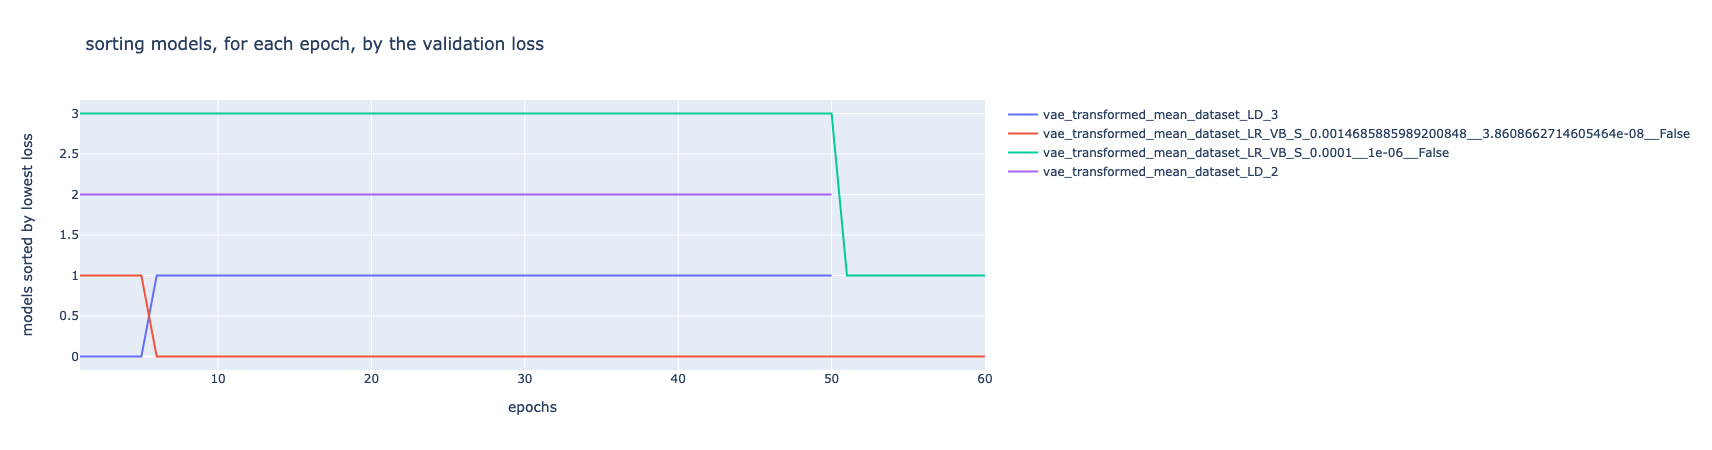

In [8]:
def plot_dict_of_sorted_metrics(d, loss_type):
    all_names = set()
    for v in d.values():
        names = set(v.keys())
        all_names |= names
    traces = {name: dict() for name in all_names}
    custom_data = {name: dict() for name in all_names}
    for epoch, sorted_names in d.items():
        for name in all_names:
            l = list(sorted_names.keys())
            if name in l:
                i = l.index(name)
                traces[name][epoch] = i
                custom_data[name][epoch] = sorted_names[name]
            
#     plt.figure(figsize=(16, 0.5 * len(all_names)))
    plotly_traces = []
    for name, trace in traces.items():
        x = list(trace.keys())
        y = list(trace.values())
        customdata = np.array(list(custom_data[name].values()))
        plotly_trace = go.Scatter(x=x, y=y, customdata=customdata, name=name, visible=visible, hovertemplate = '(%{x}, %{y}) loss: %{customdata:10.3e}')
        plotly_traces.append(plotly_trace)
#         plt.plot(x, y, label=name, linewidth=5)        
#     plt.legend()
#     plt.title(f'sorting models by {loss_type} loss, for each epoch')
#     plt.xlabel('epochs')
#     plt.ylabel('models sorted by lowest loss')
#     plt.show()
    layout = go.Layout(
        title=f'sorting models, for each epoch, by the {loss_type} loss',
        xaxis_title='epochs',
        yaxis_title='models sorted by lowest loss',      
    )
    fig = go.Figure(data=plotly_traces, layout=layout)
    iplot(fig)
    
from collections import OrderedDict
sorted_train = OrderedDict(sorted(sorted_train.items()))
sorted_validation = OrderedDict(sorted(sorted_validation.items()))
    
plot_dict_of_sorted_metrics(sorted_train, 'training')
plot_dict_of_sorted_metrics(sorted_validation, 'validation')

In [9]:
#%%

import itertools

# BE CAREFUL that if some models have not been trained until the last epoch, they could end up not being considered here while still being good models
epoch = max(sorted_validation.keys())
assert epoch == 60
candidates = list(itertools.islice(sorted_validation[epoch].items(), 10))
pprint(candidates)
instances_names = [candidate[0] for candidate in candidates]
print(instances_names)

[('vae_transformed_mean_dataset_LR_VB_S_0.0014685885989200848__3.8608662714605464e-08__False',
  array(0.12701962)),
 ('vae_transformed_mean_dataset_LR_VB_S_0.0001__1e-06__False',
  array(0.19558309))]
['vae_transformed_mean_dataset_LR_VB_S_0.0014685885989200848__3.8608662714605464e-08__False', 'vae_transformed_mean_dataset_LR_VB_S_0.0001__1e-06__False']


In [10]:
import pickle

from data import TransformedMeanDataset

class A:
    def __init__(self, model, model_id):
        self.model = model
        self.model_id = model_id
        self.instance = model + '_' + model_id
        if self.model_id == 'transformed_mean_dataset':
            self.dataset = TransformedMeanDataset
        else:
            raise ValueError(self.instance)
        self.ds_train = self.dataset('train')
        self.ds_validation = self.dataset('validation')

normalization_methods = {'vae_transformed_mean_dataset': A('vae', 'transformed_mean_dataset')}

True
<KeysViewHDF5 ['count', 'maximum', 'mean', 'sum', 'variance']>


In [11]:
from data import file_path

def the_path(instance, f):
    root = file_path(instance)
    assert os.path.isdir(root), root
    return os.path.join(root, f)

### WARNING: YOU MAY NEED TO RECREATE THE EMBEDDING FOR THE LAST EPOCH IF YOU DELETED IT FROM OTHER NOTEBOOKS

In [12]:
from models.train_vae import Vae
import ignite.distributed as idist
from h5_logger import H5Logger
import torch
from tqdm import tqdm

ds_train = TransformedMeanDataset('train')
ds_validation = TransformedMeanDataset('validation')

for i, instance in enumerate(instances):
    if i == 2:
        n = 2
    elif i == 3:
        n = 3
    else:
        n = 5
    model = Vae(in_channels=39, hidden_layer_dimensions=n, out_channels=39)
    model = model.to(idist.device())
    model.load_state_dict(torch.load(the_path(instance, 'model.torch')))
    for split in ['train', 'validation']:
        path = the_path(instance, f'embedding_{split}.hdf5')
        if os.path.isfile(path):
            os.remove(path)
        if not os.path.isfile(path):
            EPOCH = 50
            print(f'embedding not found, creating it for EPOCH = {EPOCH}, path =', path)
            embedding_training_logger = H5Logger(path)
            embedding_training_logger.clear()
            if split == 'train':
                ds = ds_train
            elif split == 'validation':
                ds = ds_validation
            else:
                raise ValueError()

            # only_first_5_samples = False
            with torch.no_grad():
                list_of_reconstructed = []
                list_of_mu = []
                list_of_log_var = []
                iterator = tqdm(ds, desc='embedding', position=0, leave=True)
                for i, data in enumerate(iterator):
                    data.to(idist.device())
                    data = torch.unsqueeze(data, 0)
                    # data = [torch.unsqueeze(x, 0) for x in data]
                    recon_batch, mu, log_var = model.forward_step(data, model)
                    ome_filename = ds.filenames[i]

                    def u(x):
                        if len(x.shape) == 3 and x.shape[0] == 1:
                            x = x.reshape(-1, x.shape[2])
                        return x

                    f = lambda x: x.cpu().detach().numpy()
                    # reconstructed = ome_dataset.scale_back(reconstructed.cpu().detach(), i)
                    a = f(u(recon_batch))
                    b = f(u(mu))
                    c = f(u(log_var))
                    data = {f'{ome_filename}/reconstructed': a,
                            f'{ome_filename}/mu': b,
                            f'{ome_filename}/log_var': c}
                    embedding_training_logger.log(EPOCH, data)

embedding:   0%|          | 0/215 [00:00<?, ?it/s]

embedding not found, creating it for EPOCH = 50, path = /data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_transformed_mean_dataset_LR_VB_S_0.0001__1e-06__False/embedding_train.hdf5


embedding:  11%|█         | 13/119 [00:00<00:00, 126.52it/s]

embedding not found, creating it for EPOCH = 50, path = /data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_transformed_mean_dataset_LR_VB_S_0.0001__1e-06__False/embedding_validation.hdf5


embedding:   5%|▍         | 10/215 [00:00<00:02, 93.18it/s]

embedding not found, creating it for EPOCH = 50, path = /data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_transformed_mean_dataset_LR_VB_S_0.0014685885989200848__3.8608662714605464e-08__False/embedding_train.hdf5


embedding:  11%|█         | 13/119 [00:00<00:00, 128.25it/s]

embedding not found, creating it for EPOCH = 50, path = /data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_transformed_mean_dataset_LR_VB_S_0.0014685885989200848__3.8608662714605464e-08__False/embedding_validation.hdf5


embedding:   5%|▍         | 10/215 [00:00<00:02, 93.76it/s]

embedding not found, creating it for EPOCH = 50, path = /data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_transformed_mean_dataset_LD_2/embedding_train.hdf5


embedding:  12%|█▏        | 14/119 [00:00<00:00, 130.31it/s]

embedding not found, creating it for EPOCH = 50, path = /data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_transformed_mean_dataset_LD_2/embedding_validation.hdf5


embedding:   5%|▍         | 10/215 [00:00<00:02, 90.35it/s]

embedding not found, creating it for EPOCH = 50, path = /data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_transformed_mean_dataset_LD_3/embedding_train.hdf5


embedding:  11%|█         | 13/119 [00:00<00:00, 129.31it/s]

embedding not found, creating it for EPOCH = 50, path = /data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_transformed_mean_dataset_LD_3/embedding_validation.hdf5


embedding: 100%|██████████| 119/119 [00:00<00:00, 128.79it/s]


In [13]:
import h5py
from data import file_path
from tqdm import tqdm

from data import file_path
def the_path(instance_folder, f):
    root = '/data/l989o/deployed/a/data/spatial_uzh_processed/a'
    assert instance_folder.startswith(root)
    return os.path.join(instance_folder, f)

class SpearmanStuff:
    pass

sinstances = [SpearmanStuff() for _ in instances]

def get_mean_spearman(ll, sinstance):
    from scipy.stats import spearmanr
    import numpy as np

    all_k = set()
    name = os.path.basename(ll)
    normalization_method = 'vae_transformed_mean_dataset'
    print(normalization_methods.keys())
    print(normalization_method)
    ds_train = normalization_methods[normalization_method].ds_train
    ds_validation = normalization_methods[normalization_method].ds_validation
    f = the_path(ll, 'embedding_train.hdf5')
    with h5py.File(f, 'r') as f5:
        assert len(f5.keys()) == 1
        k, v = f5.items().__iter__().__next__()
        if len(all_k) == 0:
            bbb = True
        all_k.add(k)
        assert len(all_k) <= 1
        if bbb:
            print(f'EPOCH {k}')

        o_train = ds_train.filenames        
        spearman_train_list = []
        for i, o in enumerate(tqdm(o_train, desc='spearamn train')):
            original = ds_train[i].numpy()
            reconstructed = v[o]['reconstructed'][...]
            assert original.shape == reconstructed.shape
            correlations = []
            for c in range(39):
                x = original[:, c]
                y = reconstructed[:, c]
                r, p_value = spearmanr(x, y)
                correlations.append(r)
            corr = np.array(correlations).reshape((1, -1))
            spearman_train_list.append(corr)
        spearman_train = np.concatenate(spearman_train_list, axis=0)
        print(spearman_train.shape)
        sinstance.spearman_train = spearman_train

    f = the_path(ll, 'embedding_validation.hdf5')
    with h5py.File(f, 'r') as f5:
        assert len(f5.keys()) == 1
        k, v = f5.items().__iter__().__next__()
        if len(all_k) == 0:
            bbb = True
        all_k.add(k)
        assert len(all_k) <= 1
        if bbb:
            print(f'EPOCH {k}')

        o_validation = ds_validation.filenames        
        spearman_validation_list = []
        for i, o in enumerate(tqdm(o_validation, desc='spearamn validation')):
            original = ds_validation[i].numpy()
            reconstructed = v[o]['reconstructed'][...]
            assert original.shape == reconstructed.shape
            correlations = []
            for c in range(39):
                x = original[:, c]
                y = reconstructed[:, c]
                r, p_value = spearmanr(x, y)
                correlations.append(r)
            corr = np.array(correlations).reshape((1, -1))
            spearman_validation_list.append(corr)
        spearman_validation = np.concatenate(spearman_validation_list, axis=0)
        print(spearman_validation.shape)
        sinstance.spearman_validation = spearman_validation
    return np.mean(spearman_train), np.mean(spearman_validation)

mean_spearman_dict = dict()

for ll, ss in zip(instances, sinstances):
    r_train, r_validation = get_mean_spearman(ll, ss)
    mean_spearman_dict[os.path.basename(ll)] = (r_train, r_validation)
print(mean_spearman_dict)
#%%

spearamn train:   1%|▏         | 3/215 [00:00<00:08, 25.05it/s]

dict_keys(['vae_transformed_mean_dataset'])
vae_transformed_mean_dataset
EPOCH epoch50


spearamn validation:   3%|▎         | 3/119 [00:00<00:04, 27.85it/s]

(215, 39)
EPOCH epoch50


spearamn train:   1%|▏         | 3/215 [00:00<00:09, 22.60it/s]

(119, 39)
dict_keys(['vae_transformed_mean_dataset'])
vae_transformed_mean_dataset
EPOCH epoch50


spearamn validation:   3%|▎         | 3/119 [00:00<00:04, 27.52it/s]

(215, 39)
EPOCH epoch50


spearamn train:   1%|▏         | 3/215 [00:00<00:08, 25.08it/s]

(119, 39)
dict_keys(['vae_transformed_mean_dataset'])
vae_transformed_mean_dataset
EPOCH epoch50


spearamn validation:   3%|▎         | 3/119 [00:00<00:04, 28.94it/s]

(215, 39)
EPOCH epoch50


spearamn train:   1%|▏         | 3/215 [00:00<00:08, 25.38it/s]

(119, 39)
dict_keys(['vae_transformed_mean_dataset'])
vae_transformed_mean_dataset
EPOCH epoch50


spearamn validation:   3%|▎         | 3/119 [00:00<00:04, 28.79it/s]

(215, 39)
EPOCH epoch50


spearamn validation: 100%|██████████| 119/119 [00:04<00:00, 28.98it/s]

(119, 39)
{'vae_transformed_mean_dataset_LR_VB_S_0.0001__1e-06__False': (0.6765152043354324, 0.6739756860173272), 'vae_transformed_mean_dataset_LR_VB_S_0.0014685885989200848__3.8608662714605464e-08__False': (0.7385191651971342, 0.7345491367993352), 'vae_transformed_mean_dataset_LD_2': (0.65935339674336, 0.6571671832745355), 'vae_transformed_mean_dataset_LD_3': (0.6880632867937251, 0.6845559917089484)}


In [14]:
from data import RawMeanDataset

raw_train = RawMeanDataset('train')
counts = [(len(a), i) for i, a in enumerate(raw_train)]
counts = sorted(counts, key=lambda x: x[0])
train_sort = np.array([c[1] for c in counts])

raw_val = RawMeanDataset('validation')
counts = [(len(a), i) for i, a in enumerate(raw_val)]
counts = sorted(counts, key=lambda x: x[0])
val_sort = np.array([c[1] for c in counts])

In [51]:
import matplotlib.pyplot as plt
import matplotlib

for name, instance in zip(instances, sinstances):
    name = os.path.basename(name)
    print(instance.spearman_validation.shape)
    a = len(instance.spearman_train)
    b = len(instance.spearman_validation)
    
    fig = plt.figure(figsize=(15, 3)) # constrained_layout=True, 
#     fig.suptitle(instance.instance)
    gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=(a, b))
    ax0_0 = fig.add_subplot(gs[0, 0])
#     plt.subplot(1, 2, 1)
    plt.matshow(instance.spearman_train[train_sort, :].transpose(), interpolation='nearest', fignum=False)
    plt.clim(-1, 1)
    plt.title(f'train')
    plt.xlabel('omes')
    plt.ylabel('channels')

#     plt.subplot(1, 2, 2)
    ax0_1 = fig.add_subplot(gs[0, 1])
    pcm = plt.matshow(instance.spearman_validation[val_sort, :].transpose(), interpolation='nearest', fignum=False)
    plt.clim(-1, 1)
    plt.title(f'validation')
    plt.xlabel('omes')
    plt.ylabel('channels')
    
    fig.colorbar(pcm, ax=[ax0_0, ax0_1], location='bottom')
        
    plt.suptitle(f'{name[:50]}... , Spearman correlation between original and reconstructed')
#     plt.tight_layout()
#     gs.tight_layout(fig)
#     gs.update(top=0.95)
#     x = 0.05
#     plt.subplots_adjust(left=x, bottom=x, right=1 - x, top=1 - x, wspace=None, hspace=0.2)
    plt.show()

(119, 39)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(119, 39)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(119, 39)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(119, 39)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [16]:
import numpy as np

all_k = set()
for instance, sinstance in zip(instances, sinstances):
    f = the_path(instance, 'embedding_train.hdf5')
    with h5py.File(f, 'r') as f5:
        assert len(f5.keys()) == 1
        k, v = f5.items().__iter__().__next__()
        if len(all_k) == 0:
            bbb = True
        all_k.add(k)
        assert len(all_k) <= 1
        if bbb:
            print(f'EPOCH {k}', flush=True)
            
        o_train = ds_train.filenames        
        original_list = []
        mu_list = []
        log_var_list = []
        for i, o in enumerate(tqdm(o_train, desc='spearamn train')):
            original = ds_train[i].clone().detach().numpy()
            mu = v[o]['mu'][...]
            log_var = v[o]['log_var'][...]
            assert mu.shape == log_var.shape
            assert len(original) == len(mu)
            original_list.append(original)
            mu_list.append(mu)
            log_var_list.append(log_var)
        sinstance.mu_list = mu_list
        sinstance.log_var_list = log_var_list
        
        sinstance.all_original = np.concatenate(original_list, axis=0)
        sinstance.all_mu = np.concatenate(mu_list, axis=0)
        sinstance.all_log_var = np.concatenate(log_var_list, axis=0)

EPOCH epoch50


spearamn train: 100%|██████████| 215/215 [00:01<00:00, 108.55it/s]

EPOCH epoch50



spearamn train: 100%|██████████| 215/215 [00:01<00:00, 108.63it/s]

EPOCH epoch50



spearamn train: 100%|██████████| 215/215 [00:01<00:00, 107.77it/s]

EPOCH epoch50



spearamn train: 100%|██████████| 215/215 [00:01<00:00, 108.08it/s]


In [17]:
import scanpy as sc
import anndata as ad

import numpy as np
random_choice = np.random.choice(len(sinstances[0].all_original), 10000, replace=False)

plt.style.use('default')

----------------------------------------------------------------------------------------------------
/data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_transformed_mean_dataset_LR_VB_S_0.0001__1e-06__False


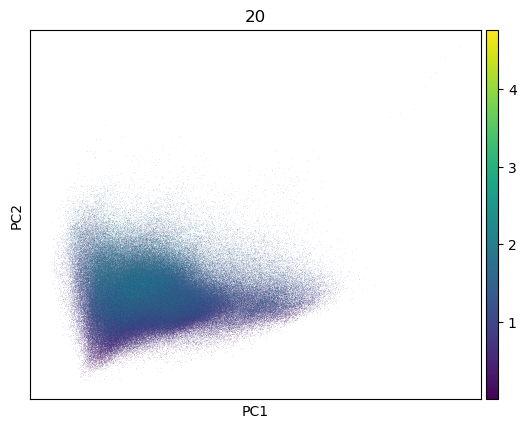

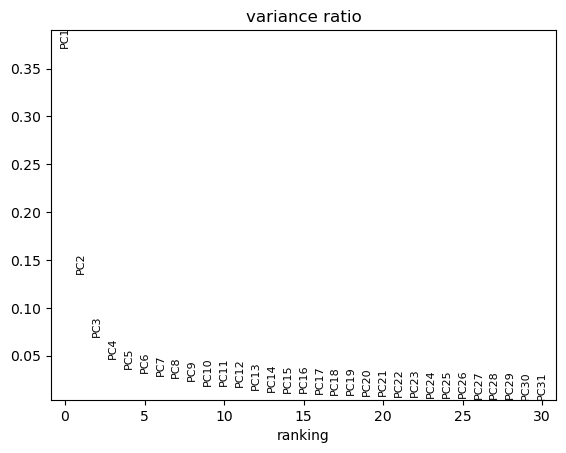

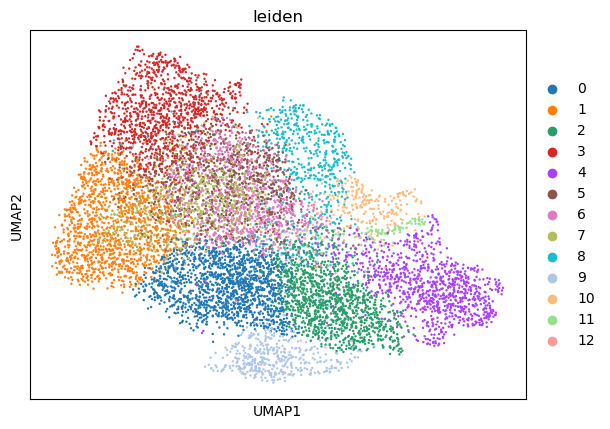

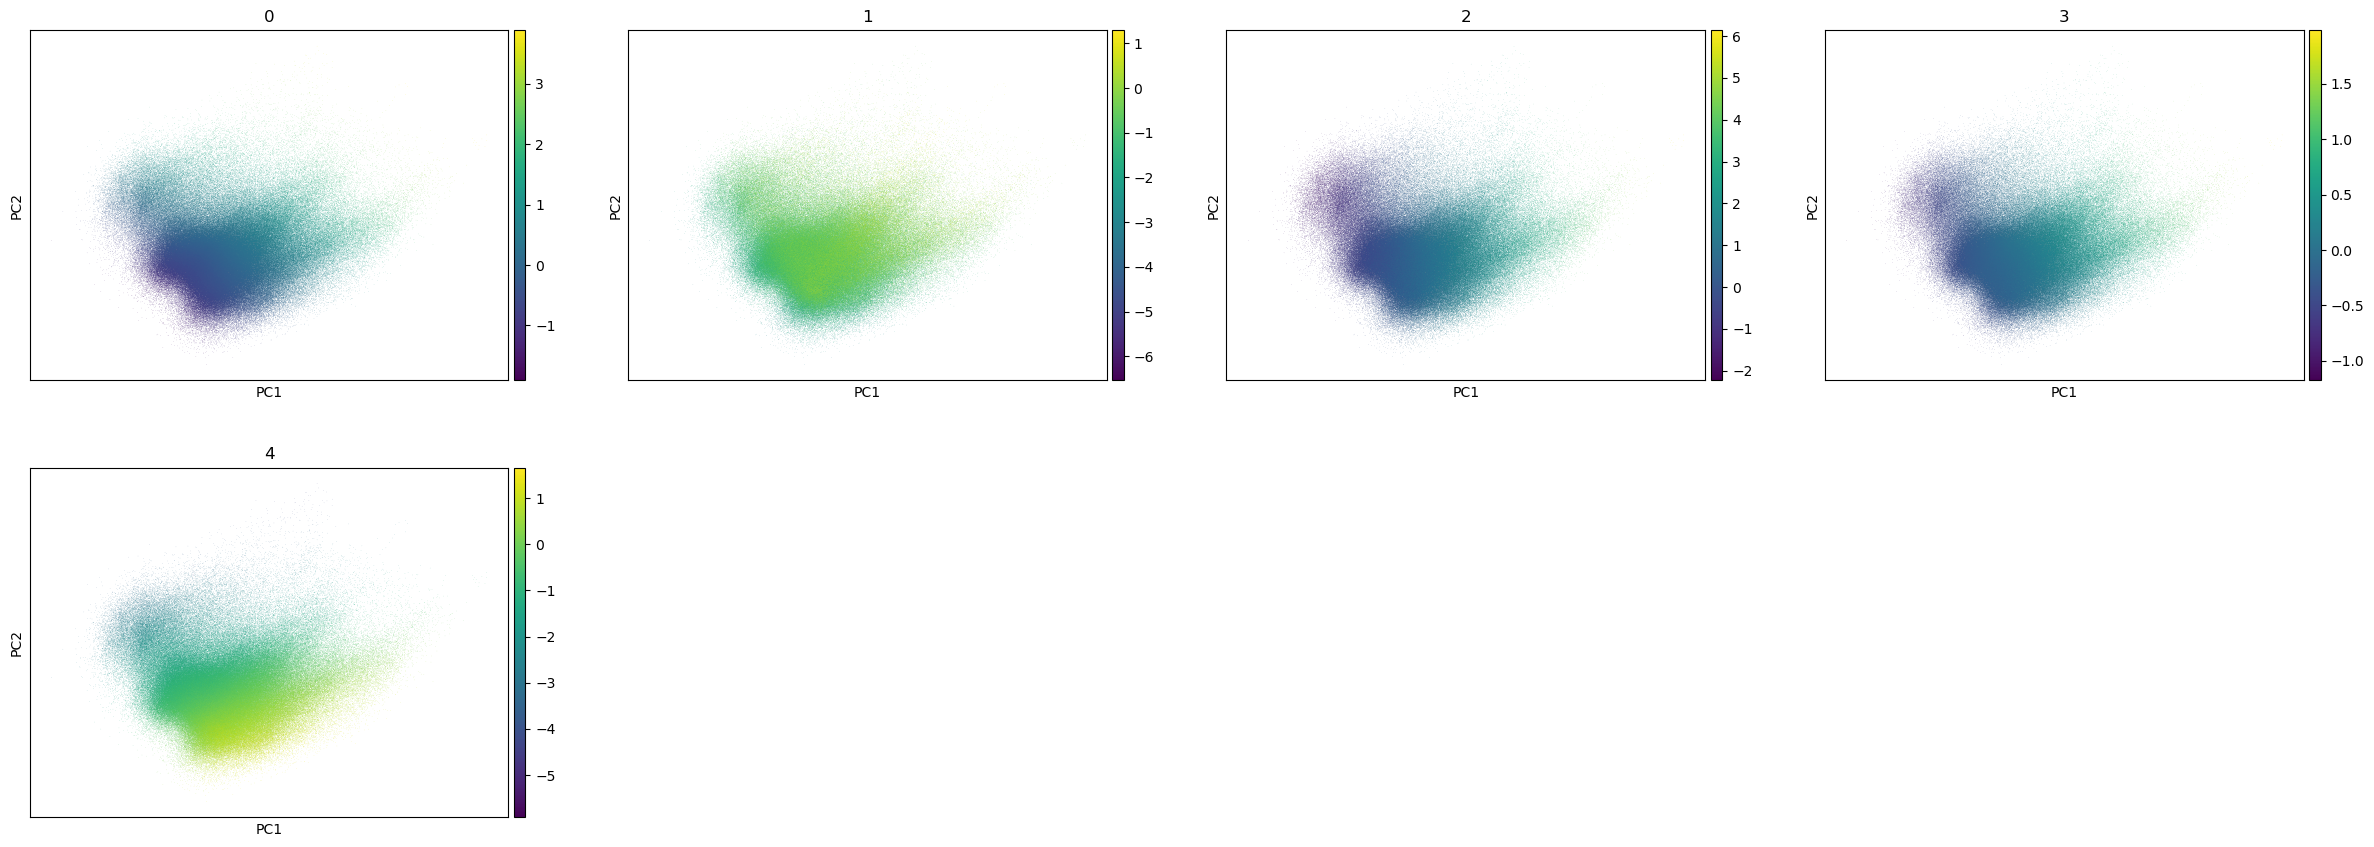

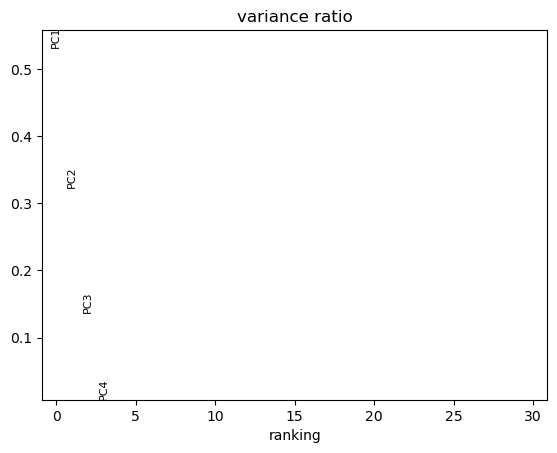

{'params': {'zero_center': True, 'use_highly_variable': False}, 'variance': array([1.33958759, 0.81559502, 0.34543393, 0.0196478 ]), 'variance_ratio': array([0.53152827, 0.32361587, 0.137063  , 0.00779595])}


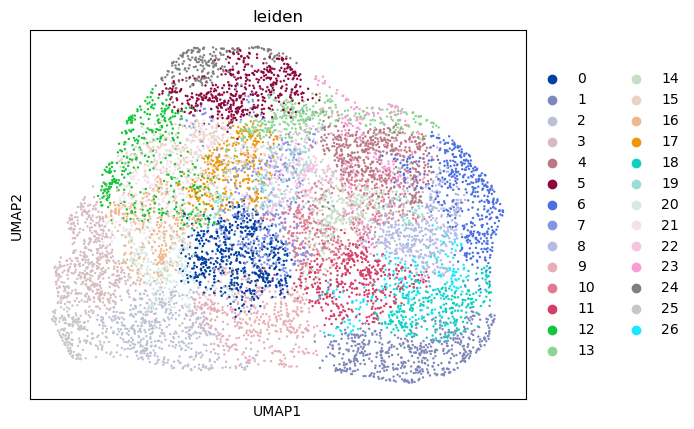

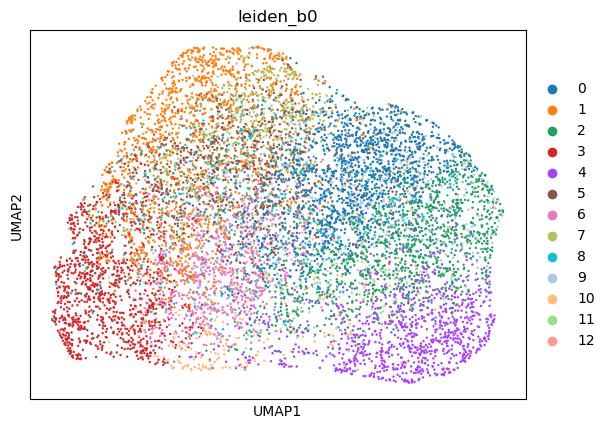

In [20]:
instance = instances[0]
sinstance = sinstances[0]

print('-' * 100)
print(instance)
a0 = ad.AnnData(sinstance.all_original)
a1 = ad.AnnData(sinstance.all_mu)
a2 = ad.AnnData(sinstance.all_log_var)

sc.tl.pca(a0, svd_solver='arpack')
sc.pl.pca(a0, color='20')
sc.pl.pca_variance_ratio(a0)
# sc.pl.pca_variance_ratio(a0, log=True)
b0 = a0[random_choice, :].copy()
sc.pp.neighbors(b0)
sc.tl.leiden(b0)
sc.tl.umap(b0)
sc.pl.umap(b0, color='leiden')

sc.tl.pca(a1, svd_solver='arpack')
sc.pl.pca(a1, color=['0', '1', '2', '3', '4'])

sc.pl.pca_variance_ratio(a1)
print(a1.uns['pca'])
b1 = a1[random_choice, :].copy()
sc.pp.neighbors(b1)
sc.tl.leiden(b1)
sc.tl.umap(b1)
sc.pl.umap(b1, color='leiden')

b1.obs['leiden_b0'] = b0.obs['leiden']
sc.pl.umap(b1, color='leiden_b0')

----------------------------------------------------------------------------------------------------
/data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_transformed_mean_dataset_LR_VB_S_0.0014685885989200848__3.8608662714605464e-08__False


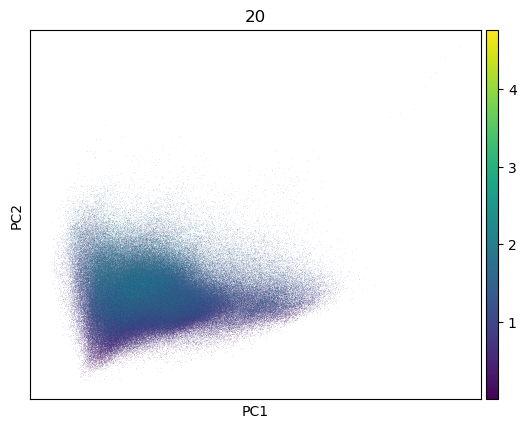

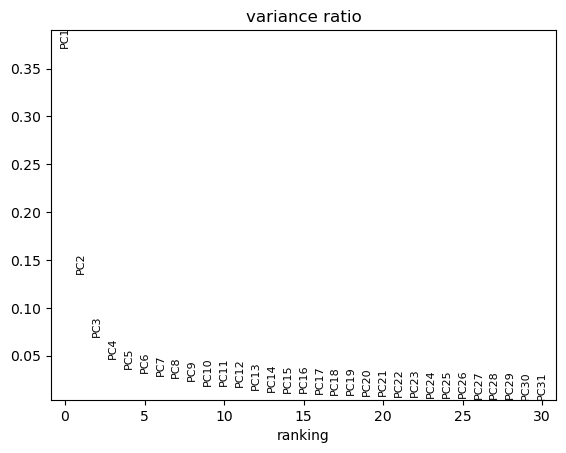

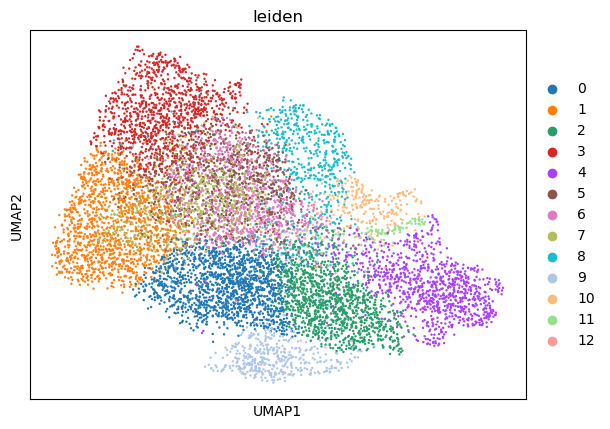

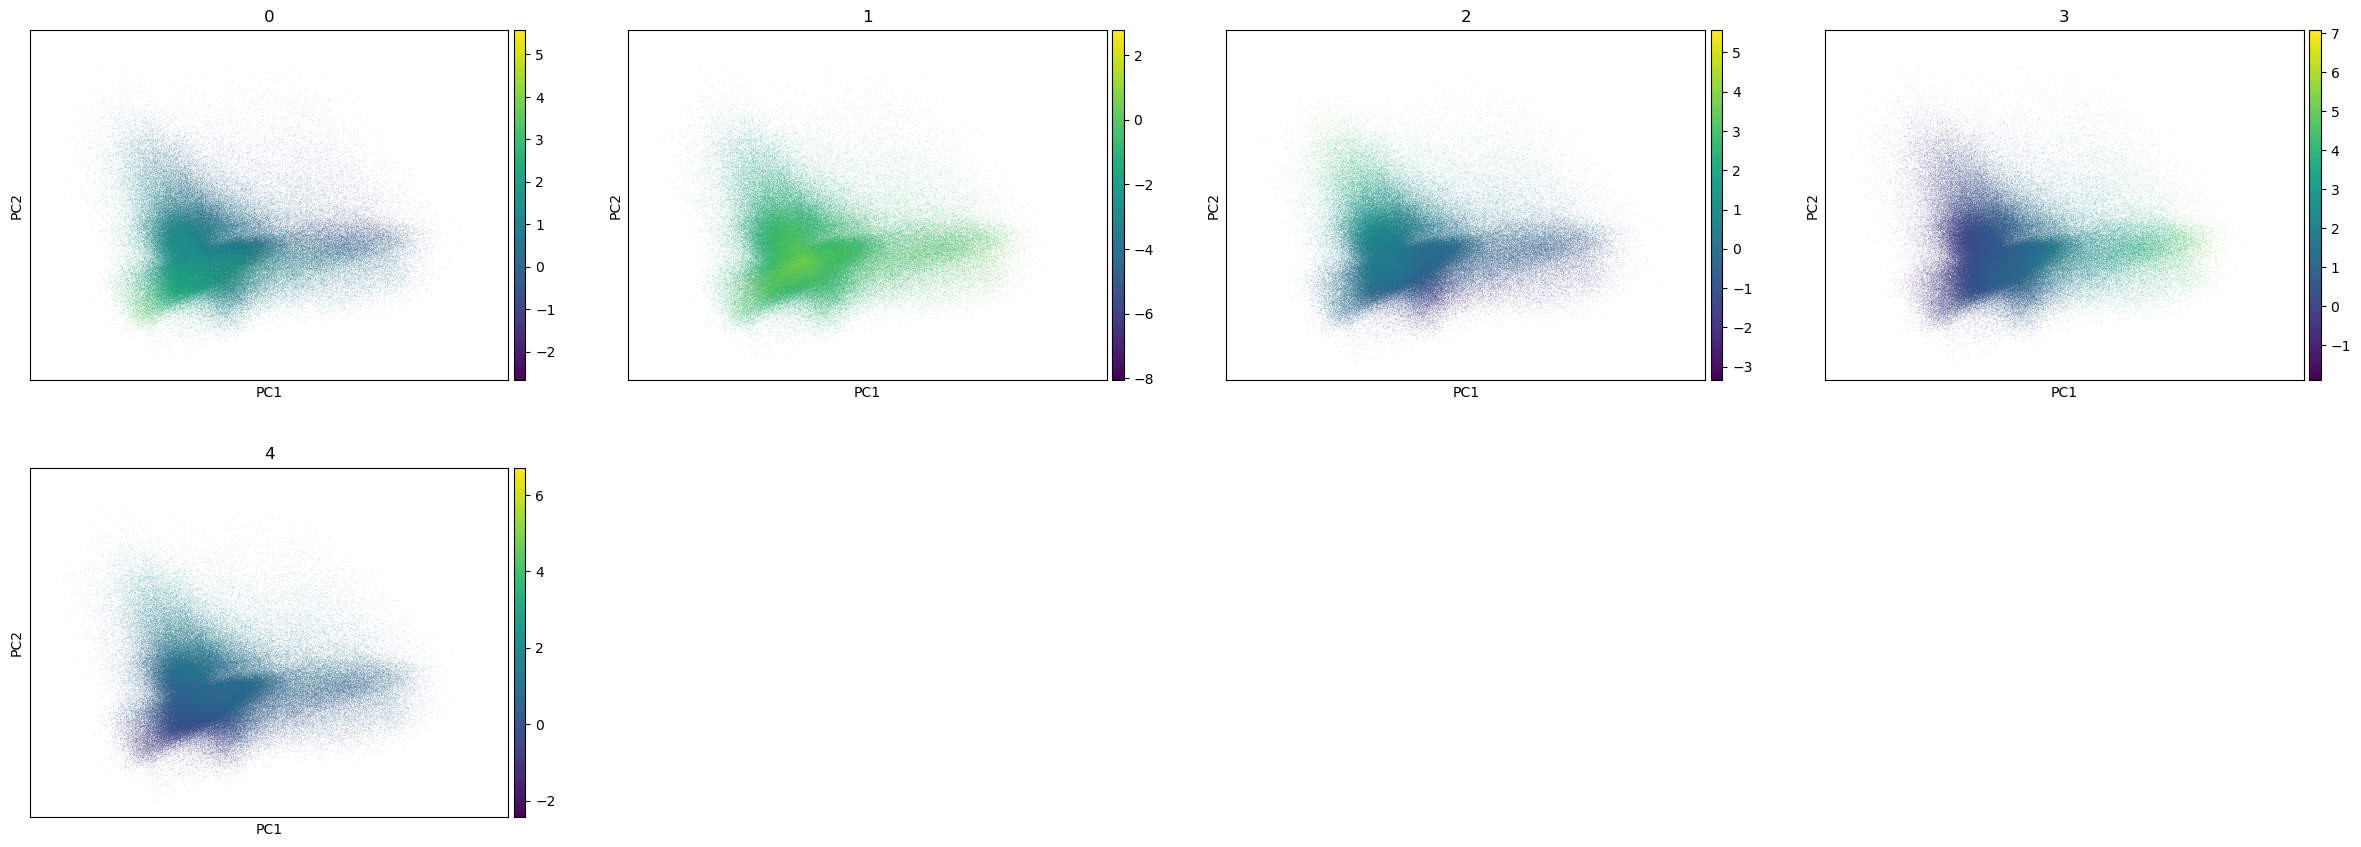

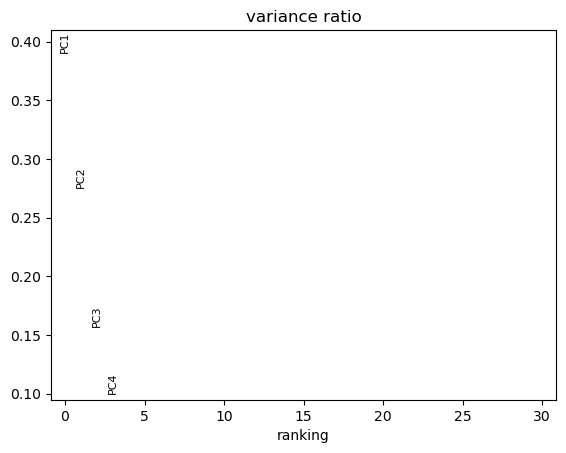

{'params': {'zero_center': True, 'use_highly_variable': False}, 'variance': array([1.34979103, 0.95157703, 0.54173858, 0.3451143 ]), 'variance_ratio': array([0.39019924, 0.27508305, 0.15660645, 0.09976606])}


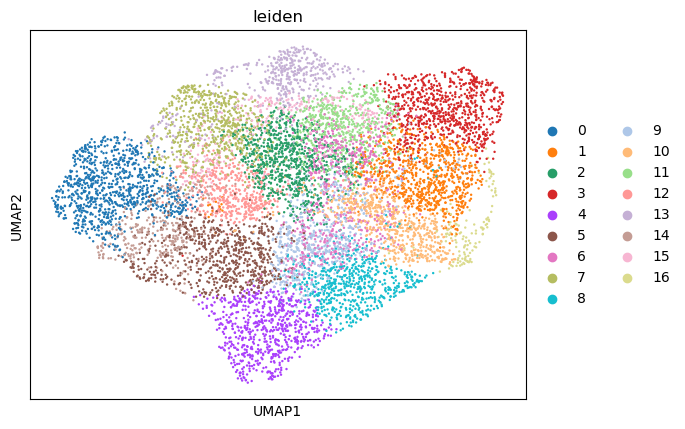

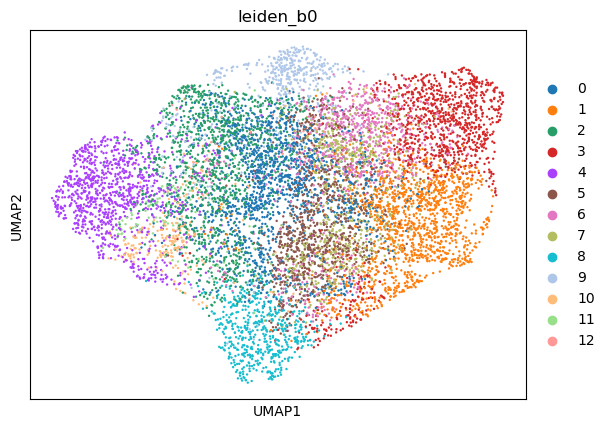

In [21]:
instance = instances[1]
sinstance = sinstances[1]

print('-' * 100)
print(instance)
a0 = ad.AnnData(sinstance.all_original)
a1 = ad.AnnData(sinstance.all_mu)
a2 = ad.AnnData(sinstance.all_log_var)

sc.tl.pca(a0, svd_solver='arpack')
sc.pl.pca(a0, color='20')
sc.pl.pca_variance_ratio(a0)
# sc.pl.pca_variance_ratio(a0, log=True)
b0 = a0[random_choice, :].copy()
sc.pp.neighbors(b0)
sc.tl.leiden(b0)
sc.tl.umap(b0)
sc.pl.umap(b0, color='leiden')

sc.tl.pca(a1, svd_solver='arpack')
sc.pl.pca(a1, color=['0', '1', '2', '3', '4'])

sc.pl.pca_variance_ratio(a1)
print(a1.uns['pca'])
b1 = a1[random_choice, :].copy()
sc.pp.neighbors(b1)
sc.tl.leiden(b1)
sc.tl.umap(b1)
sc.pl.umap(b1, color='leiden')

b1.obs['leiden_b0'] = b0.obs['leiden']
sc.pl.umap(b1, color='leiden_b0')

# 2 dims

----------------------------------------------------------------------------------------------------
/data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_transformed_mean_dataset_LD_2


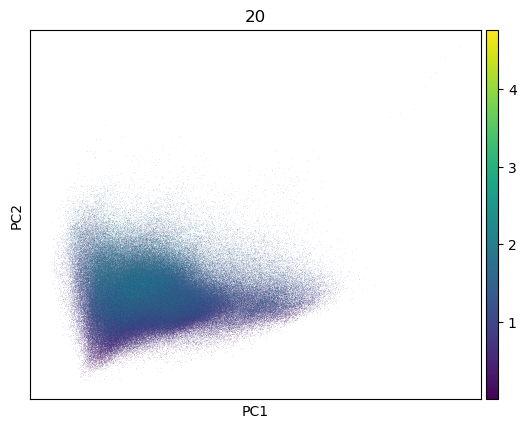

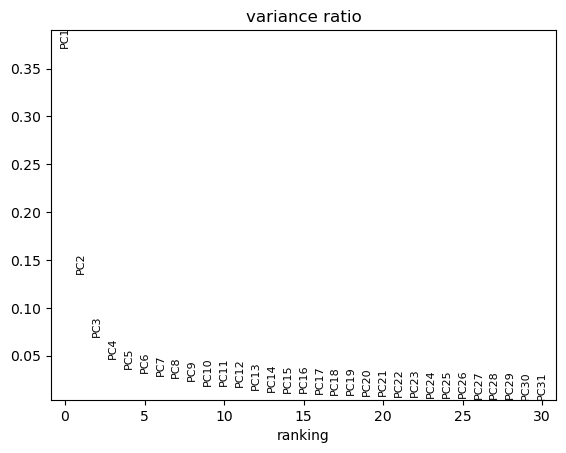

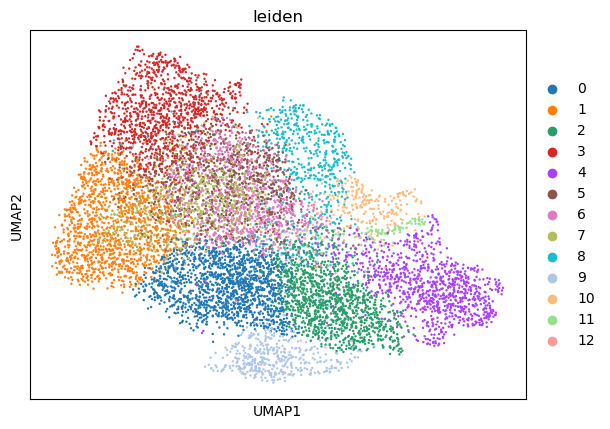

In [22]:
instance = instances[2]
sinstance = sinstances[2]

print('-' * 100)
print(instance)
a0 = ad.AnnData(sinstance.all_original)
a1 = ad.AnnData(sinstance.all_mu)
a2 = ad.AnnData(sinstance.all_log_var)

sc.tl.pca(a0, svd_solver='arpack')
sc.pl.pca(a0, color='20')
sc.pl.pca_variance_ratio(a0)
# sc.pl.pca_variance_ratio(a0, log=True)
b0 = a0[random_choice, :].copy()
sc.pp.neighbors(b0)
sc.tl.leiden(b0)
sc.tl.umap(b0)
sc.pl.umap(b0, color='leiden')

sc.tl.pca(a1, svd_solver='arpack')

In [87]:
import seaborn as sns

for k, v in sc.pl.palettes.__dict__.items():
    if type(v) == list:
        print(k)
        display(sns.color_palette(v))
        print()

vega_10


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]


vega_10_scanpy


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.15294117647058825, 0.6196078431372549, 0.40784313725490196),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.6666666666666666, 0.25098039215686274, 0.9882352941176471),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7098039215686275, 0.7411764705882353, 0.3803921568627451),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]


vega_20


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]


vega_20_scanpy


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.15294117647058825, 0.6196078431372549, 0.40784313725490196),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.6666666666666666, 0.25098039215686274, 0.9882352941176471),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.7098039215686275, 0.7411764705882353, 0.3803921568627451),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745),
 (0.6784313725490196, 0.28627450980392155, 0.2901960784313726),
 (0.5490196078431373, 0.42745098039215684, 0.19215686274509805)]


default_20


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.15294117647058825, 0.6196078431372549, 0.40784313725490196),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.6666666666666666, 0.25098039215686274, 0.9882352941176471),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.7098039215686275, 0.7411764705882353, 0.3803921568627451),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745),
 (0.6784313725490196, 0.28627450980392155, 0.2901960784313726),
 (0.5490196078431373, 0.42745098039215684, 0.19215686274509805)]


zeileis_28


[(0.00784313725490196, 0.24705882352941178, 0.6470588235294118),
 (0.49019607843137253, 0.5294117647058824, 0.7254901960784313),
 (0.7450980392156863, 0.7568627450980392, 0.8313725490196079),
 (0.8392156862745098, 0.7372549019607844, 0.7529411764705882),
 (0.7333333333333333, 0.4666666666666667, 0.5176470588235295),
 (0.5568627450980392, 0.023529411764705882, 0.23137254901960785),
 (0.2901960784313726, 0.43529411764705883, 0.8901960784313725),
 (0.5215686274509804, 0.5843137254901961, 0.8823529411764706),
 (0.7098039215686275, 0.7333333333333333, 0.8901960784313725),
 (0.9019607843137255, 0.6862745098039216, 0.7254901960784313),
 (0.8784313725490196, 0.4823529411764706, 0.5686274509803921),
 (0.8274509803921568, 0.24705882352941178, 0.41568627450980394),
 (0.06666666666666667, 0.7764705882352941, 0.2196078431372549),
 (0.5529411764705883, 0.8352941176470589, 0.5764705882352941),
 (0.7764705882352941, 0.8705882352941177, 0.7803921568627451),
 (0.9176470588235294, 0.8274509803921568, 0.7764705882352941),
 (0.9411764705882353, 0.7254901960784313, 0.5529411764705883),
 (0.9372549019607843, 0.592156862745098, 0.03137254901960784),
 (0.058823529411764705, 0.8117647058823529, 0.7529411764705882),
 (0.611764705882353, 0.8705882352941177, 0.8392156862745098),
 (0.8352941176470589, 0.9176470588235294, 0.9058823529411765),
 (0.9529411764705882, 0.8823529411764706, 0.9215686274509803),
 (0.9647058823529412, 0.7686274509803922, 0.8823529411764706),
 (0.9686274509803922, 0.611764705882353, 0.8313725490196079),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.10980392156862745, 0.9019607843137255, 1.0),
 (0.2, 0.4, 0.0)]


default_28


[(0.00784313725490196, 0.24705882352941178, 0.6470588235294118),
 (0.49019607843137253, 0.5294117647058824, 0.7254901960784313),
 (0.7450980392156863, 0.7568627450980392, 0.8313725490196079),
 (0.8392156862745098, 0.7372549019607844, 0.7529411764705882),
 (0.7333333333333333, 0.4666666666666667, 0.5176470588235295),
 (0.5568627450980392, 0.023529411764705882, 0.23137254901960785),
 (0.2901960784313726, 0.43529411764705883, 0.8901960784313725),
 (0.5215686274509804, 0.5843137254901961, 0.8823529411764706),
 (0.7098039215686275, 0.7333333333333333, 0.8901960784313725),
 (0.9019607843137255, 0.6862745098039216, 0.7254901960784313),
 (0.8784313725490196, 0.4823529411764706, 0.5686274509803921),
 (0.8274509803921568, 0.24705882352941178, 0.41568627450980394),
 (0.06666666666666667, 0.7764705882352941, 0.2196078431372549),
 (0.5529411764705883, 0.8352941176470589, 0.5764705882352941),
 (0.7764705882352941, 0.8705882352941177, 0.7803921568627451),
 (0.9176470588235294, 0.8274509803921568, 0.7764705882352941),
 (0.9411764705882353, 0.7254901960784313, 0.5529411764705883),
 (0.9372549019607843, 0.592156862745098, 0.03137254901960784),
 (0.058823529411764705, 0.8117647058823529, 0.7529411764705882),
 (0.611764705882353, 0.8705882352941177, 0.8392156862745098),
 (0.8352941176470589, 0.9176470588235294, 0.9058823529411765),
 (0.9529411764705882, 0.8823529411764706, 0.9215686274509803),
 (0.9647058823529412, 0.7686274509803922, 0.8823529411764706),
 (0.9686274509803922, 0.611764705882353, 0.8313725490196079),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.10980392156862745, 0.9019607843137255, 1.0),
 (0.2, 0.4, 0.0)]


godsnot_102


[(1.0, 1.0, 0.0),
 (0.10980392156862745, 0.9019607843137255, 1.0),
 (1.0, 0.20392156862745098, 1.0),
 (1.0, 0.2901960784313726, 0.27450980392156865),
 (0.0, 0.5372549019607843, 0.2549019607843137),
 (0.0, 0.43529411764705883, 0.6509803921568628),
 (0.6392156862745098, 0.0, 0.34901960784313724),
 (1.0, 0.8588235294117647, 0.8980392156862745),
 (0.47843137254901963, 0.28627450980392155, 0.0),
 (0.0, 0.0, 0.6509803921568628),
 (0.38823529411764707, 1.0, 0.6745098039215687),
 (0.7176470588235294, 0.592156862745098, 0.3843137254901961),
 (0.0, 0.30196078431372547, 0.2627450980392157),
 (0.5607843137254902, 0.6901960784313725, 1.0),
 (0.6, 0.49019607843137253, 0.5294117647058824),
 (0.35294117647058826, 0.0, 0.027450980392156862),
 (0.5019607843137255, 0.5882352941176471, 0.5764705882352941),
 (0.41568627450980394, 0.22745098039215686, 0.2980392156862745),
 (0.10588235294117647, 0.26666666666666666, 0.0),
 (0.30980392156862746, 0.7764705882352941, 0.00392156862745098),
 (0.23137254901960785, 0.36470588235294116, 1.0),
 (0.2901960784313726, 0.23137254901960785, 0.3254901960784314),
 (1.0, 0.1843137254901961, 0.5019607843137255),
 (0.3803921568627451, 0.3803921568627451, 0.35294117647058826),
 (0.7294117647058823, 0.03529411764705882, 0.0),
 (0.4196078431372549, 0.4745098039215686, 0.0),
 (0.0, 0.7607843137254902, 0.6274509803921569),
 (1.0, 0.6666666666666666, 0.5725490196078431),
 (1.0, 0.5647058823529412, 0.788235294117647),
 (0.7254901960784313, 0.011764705882352941, 0.6666666666666666),
 (0.8196078431372549, 0.3803921568627451, 0.0),
 (0.8666666666666667, 0.9372549019607843, 1.0),
 (0.0, 0.0, 0.20784313725490197),
 (0.4823529411764706, 0.30980392156862746, 0.29411764705882354),
 (0.6313725490196078, 0.7607843137254902, 0.6),
 (0.18823529411764706, 0.0, 0.09411764705882353),
 (0.0392156862745098, 0.6509803921568628, 0.8470588235294118),
 (0.00392156862745098, 0.2, 0.28627450980392155),
 (0.0, 0.5176470588235295, 0.43529411764705883),
 (0.21568627450980393, 0.12941176470588237, 0.00392156862745098),
 (1.0, 0.7098039215686275, 0.0),
 (0.7607843137254902, 1.0, 0.9294117647058824),
 (0.6274509803921569, 0.4745098039215686, 0.7490196078431373),
 (0.8, 0.027450980392156862, 0.26666666666666666),
 (0.7529411764705882, 0.7254901960784313, 0.6980392156862745),
 (0.7607843137254902, 1.0, 0.6),
 (0.0, 0.11764705882352941, 0.03529411764705882),
 (0.0, 0.2823529411764706, 0.611764705882353),
 (0.43529411764705883, 0.0, 0.3843137254901961),
 (0.047058823529411764, 0.7411764705882353, 0.4),
 (0.9333333333333333, 0.7647058823529411, 1.0),
 (0.27058823529411763, 0.42745098039215684, 0.4588235294117647),
 (0.7176470588235294, 0.4823529411764706, 0.40784313725490196),
 (0.47843137254901963, 0.5294117647058824, 0.6313725490196078),
 (0.47058823529411764, 0.5529411764705883, 0.4),
 (0.5333333333333333, 0.3333333333333333, 0.47058823529411764),
 (0.9803921568627451, 0.8156862745098039, 0.6235294117647059),
 (1.0, 0.5411764705882353, 0.6039215686274509),
 (0.8196078431372549, 0.3411764705882353, 0.6274509803921569),
 (0.7450980392156863, 0.7686274509803922, 0.34901960784313724),
 (0.27058823529411763, 0.4, 0.2823529411764706),
 (0.0, 0.5254901960784314, 0.9294117647058824),
 (0.5333333333333333, 0.43529411764705883, 0.2980392156862745),
 (0.20392156862745098, 0.21176470588235294, 0.17647058823529413),
 (0.7058823529411765, 0.6588235294117647, 0.7411764705882353),
 (0.0, 0.6509803921568628, 0.6666666666666666),
 (0.27058823529411763, 0.17254901960784313, 0.17254901960784313),
 (0.38823529411764707, 0.38823529411764707, 0.4588235294117647),
 (0.6392156862745098, 0.7843137254901961, 0.788235294117647),
 (1.0, 0.5686274509803921, 0.24705882352941178),
 (0.5764705882352941, 0.5411764705882353, 0.5058823529411764),
 (0.3411764705882353, 0.3254901960784314, 0.1607843137254902),
 (0.0, 0.996078431372549, 0.8117647058823529),
 (0.6901960784313725, 0.3568627450980392, 0.43529411764705883),
 (0.5490196078431373, 0.8156862745098039, 1.0),
 (0.23137254901960785, 0.5


default_102


[(1.0, 1.0, 0.0),
 (0.10980392156862745, 0.9019607843137255, 1.0),
 (1.0, 0.20392156862745098, 1.0),
 (1.0, 0.2901960784313726, 0.27450980392156865),
 (0.0, 0.5372549019607843, 0.2549019607843137),
 (0.0, 0.43529411764705883, 0.6509803921568628),
 (0.6392156862745098, 0.0, 0.34901960784313724),
 (1.0, 0.8588235294117647, 0.8980392156862745),
 (0.47843137254901963, 0.28627450980392155, 0.0),
 (0.0, 0.0, 0.6509803921568628),
 (0.38823529411764707, 1.0, 0.6745098039215687),
 (0.7176470588235294, 0.592156862745098, 0.3843137254901961),
 (0.0, 0.30196078431372547, 0.2627450980392157),
 (0.5607843137254902, 0.6901960784313725, 1.0),
 (0.6, 0.49019607843137253, 0.5294117647058824),
 (0.35294117647058826, 0.0, 0.027450980392156862),
 (0.5019607843137255, 0.5882352941176471, 0.5764705882352941),
 (0.41568627450980394, 0.22745098039215686, 0.2980392156862745),
 (0.10588235294117647, 0.26666666666666666, 0.0),
 (0.30980392156862746, 0.7764705882352941, 0.00392156862745098),
 (0.23137254901960785, 0.36470588235294116, 1.0),
 (0.2901960784313726, 0.23137254901960785, 0.3254901960784314),
 (1.0, 0.1843137254901961, 0.5019607843137255),
 (0.3803921568627451, 0.3803921568627451, 0.35294117647058826),
 (0.7294117647058823, 0.03529411764705882, 0.0),
 (0.4196078431372549, 0.4745098039215686, 0.0),
 (0.0, 0.7607843137254902, 0.6274509803921569),
 (1.0, 0.6666666666666666, 0.5725490196078431),
 (1.0, 0.5647058823529412, 0.788235294117647),
 (0.7254901960784313, 0.011764705882352941, 0.6666666666666666),
 (0.8196078431372549, 0.3803921568627451, 0.0),
 (0.8666666666666667, 0.9372549019607843, 1.0),
 (0.0, 0.0, 0.20784313725490197),
 (0.4823529411764706, 0.30980392156862746, 0.29411764705882354),
 (0.6313725490196078, 0.7607843137254902, 0.6),
 (0.18823529411764706, 0.0, 0.09411764705882353),
 (0.0392156862745098, 0.6509803921568628, 0.8470588235294118),
 (0.00392156862745098, 0.2, 0.28627450980392155),
 (0.0, 0.5176470588235295, 0.43529411764705883),
 (0.21568627450980393, 0.12941176470588237, 0.00392156862745098),
 (1.0, 0.7098039215686275, 0.0),
 (0.7607843137254902, 1.0, 0.9294117647058824),
 (0.6274509803921569, 0.4745098039215686, 0.7490196078431373),
 (0.8, 0.027450980392156862, 0.26666666666666666),
 (0.7529411764705882, 0.7254901960784313, 0.6980392156862745),
 (0.7607843137254902, 1.0, 0.6),
 (0.0, 0.11764705882352941, 0.03529411764705882),
 (0.0, 0.2823529411764706, 0.611764705882353),
 (0.43529411764705883, 0.0, 0.3843137254901961),
 (0.047058823529411764, 0.7411764705882353, 0.4),
 (0.9333333333333333, 0.7647058823529411, 1.0),
 (0.27058823529411763, 0.42745098039215684, 0.4588235294117647),
 (0.7176470588235294, 0.4823529411764706, 0.40784313725490196),
 (0.47843137254901963, 0.5294117647058824, 0.6313725490196078),
 (0.47058823529411764, 0.5529411764705883, 0.4),
 (0.5333333333333333, 0.3333333333333333, 0.47058823529411764),
 (0.9803921568627451, 0.8156862745098039, 0.6235294117647059),
 (1.0, 0.5411764705882353, 0.6039215686274509),
 (0.8196078431372549, 0.3411764705882353, 0.6274509803921569),
 (0.7450980392156863, 0.7686274509803922, 0.34901960784313724),
 (0.27058823529411763, 0.4, 0.2823529411764706),
 (0.0, 0.5254901960784314, 0.9294117647058824),
 (0.5333333333333333, 0.43529411764705883, 0.2980392156862745),
 (0.20392156862745098, 0.21176470588235294, 0.17647058823529413),
 (0.7058823529411765, 0.6588235294117647, 0.7411764705882353),
 (0.0, 0.6509803921568628, 0.6666666666666666),
 (0.27058823529411763, 0.17254901960784313, 0.17254901960784313),
 (0.38823529411764707, 0.38823529411764707, 0.4588235294117647),
 (0.6392156862745098, 0.7843137254901961, 0.788235294117647),
 (1.0, 0.5686274509803921, 0.24705882352941178),
 (0.5764705882352941, 0.5411764705882353, 0.5058823529411764),
 (0.3411764705882353, 0.3254901960784314, 0.1607843137254902),
 (0.0, 0.996078431372549, 0.8117647058823529),
 (0.6901960784313725, 0.3568627450980392, 0.43529411764705883),
 (0.5490196078431373, 0.8156862745098039, 1.0),
 (0.23137254901960785, 0.5

In [51]:
b0.obs['leiden']
len(b0.obs['leiden'].to_numpy().astype(np.int))

10000

13
13


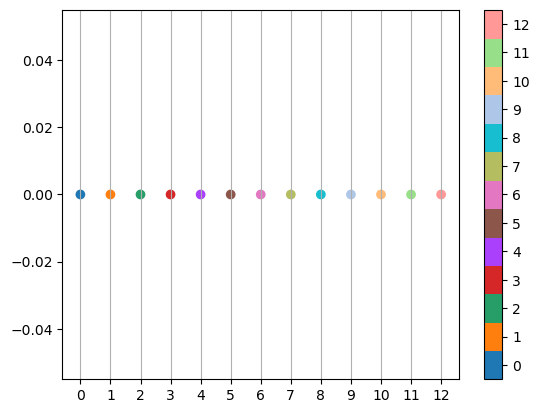

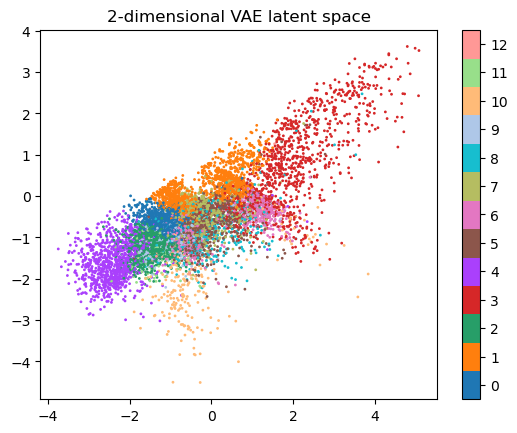

In [159]:
u = a1.X[random_choice, :]
n = len(set(b0.obs['leiden'].tolist()))
cmap = matplotlib.colors.ListedColormap(sc.pl.palettes.default_20[:n])
print(len(cmap.colors))
print(n)
    
plt.figure()
plt.scatter(np.arange(0, n), [0] * n, c=np.arange(0, n), cmap=cmap)
plt.xticks(np.arange(0, n))
ax = plt.gca()
ax.xaxis.grid()
cb = plt.colorbar()
loc = np.linspace(0, n - 1, 2 * n + 1)[1::2]
cb.set_ticks(loc)
cb.set_ticklabels(np.arange(0, n))
plt.show()

plt.figure()
plt.title('2-dimensional VAE latent space')
plt.scatter(u[:, 0], u[:, 1], s=1, c=b0.obs['leiden'].to_numpy().astype(np.int), cmap=cmap)
cb = plt.colorbar()
loc = np.linspace(0, n - 1, 2 * n + 1)[1::2]
cb.set_ticks(loc)
cb.set_ticklabels(np.arange(0, n))
plt.show()

# 3 dims

----------------------------------------------------------------------------------------------------
/data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_transformed_mean_dataset_LD_3


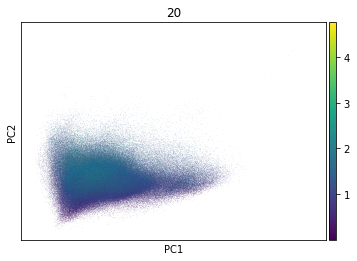

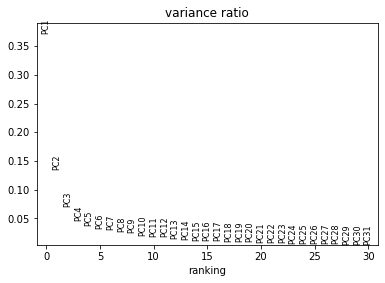

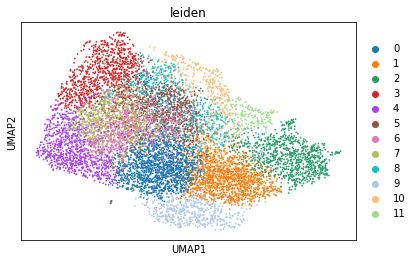

In [23]:
%matplotlib inline

instance = instances[3]
sinstance = sinstances[3]

print('-' * 100)
print(instance)
a0 = ad.AnnData(sinstance.all_original)
a1 = ad.AnnData(sinstance.all_mu)
a2 = ad.AnnData(sinstance.all_log_var)

sc.tl.pca(a0, svd_solver='arpack')
sc.pl.pca(a0, color='20')
sc.pl.pca_variance_ratio(a0)
# sc.pl.pca_variance_ratio(a0, log=True)
b0 = a0[random_choice, :].copy()
sc.pp.neighbors(b0)
sc.tl.leiden(b0)
sc.tl.umap(b0)
sc.pl.umap(b0, color='leiden')

In [30]:
sc.tl.umap(b0, n_components=3)

In [50]:
%matplotlib widget
sc.pl.umap(b0, color='leiden', projection='3d')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [34]:
%matplotlib inline

In [49]:
%matplotlib widget
plt.style.use('default')
u = a1.X[random_choice, :]
n = len(set(b0.obs['leiden'].tolist()))
cmap = matplotlib.colors.ListedColormap(sc.pl.palettes.default_20[:n])
print(len(cmap.colors))
print(u.shape)
print(n)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.set_title('3-dimensional VAE latent space')
mappable = ax.scatter(u[:, 0], u[:, 1], u[:, 2], s=1, c=b0.obs['leiden'].to_numpy().astype(np.int), cmap=cmap)
plt.show()

# plt.figure()

# plt.scatter(u[:, 0], u[:, 1], s=1, c=b0.obs['leiden'].to_numpy().astype(np.int), cmap=cmap)
# cb = plt.colorbar()
# loc = np.linspace(0, n - 1, 2 * n + 1)[1::2]
# cb.set_ticks(loc)
# cb.set_ticklabels(np.arange(0, n))
# plt.show()

12
(10000, 3)
12


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [36]:
%matplotlib inline